In [5]:
import os
import cv2
from sklearn.model_selection import train_test_split

# Define paths relative to the notebook directory
base_dir = "../OfficeCaltechDomainAdaptation/images"
amazon_dir = os.path.join(base_dir, "amazon")

# Initialize a dictionary to store images by category
categories = {}
for category in os.listdir(amazon_dir):
    category_path = os.path.join(amazon_dir, category)
    if os.path.isdir(category_path):
        categories[category] = []
        # Loop through each image in the category directory
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            # Read image in grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                categories[category].append(image)

# Print the number of images in each category
for category, images in categories.items():
    print(f"Category '{category}' contains {len(images)} images.")

# Create data and labels for the Amazon subset
X = []
y = []
label_map = {category: idx for idx, category in enumerate(categories.keys())}  # Map category names to indices
for category, images in categories.items():
    for image in images:
        X.append(image)
        y.append(label_map[category])

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")


Category 'backpack' contains 92 images.
Category 'bike' contains 82 images.
Category 'calculator' contains 94 images.
Category 'headphones' contains 99 images.
Category 'keyboard' contains 100 images.
Category 'laptop' contains 100 images.
Category 'monitor' contains 99 images.
Category 'mouse' contains 100 images.
Category 'mug' contains 94 images.
Category 'projector' contains 98 images.
Training set: 766 images
Validation set: 192 images


Training set: 766 LBP feature vectors
Validation set: 192 LBP feature vectors


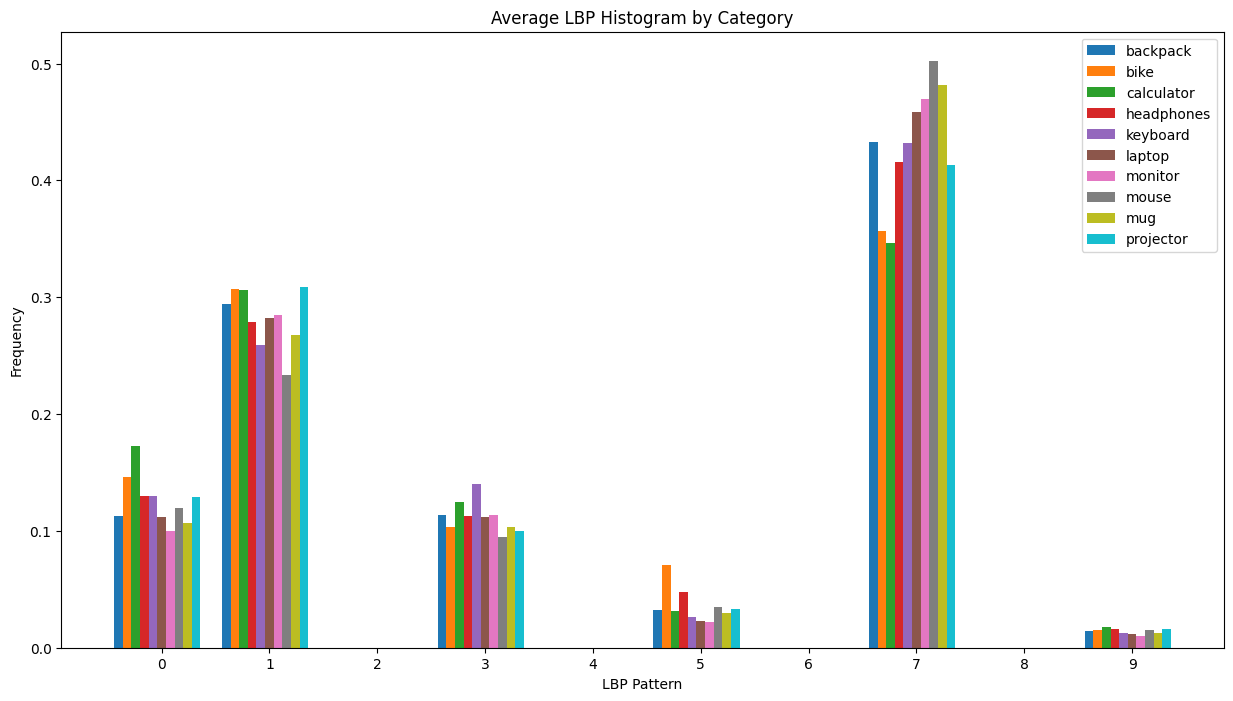

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split

# Parameters for rotation-invariant LBP
P = 8  # Number of circularly symmetric neighbor set points
R = 1  # Radius of circle

def extract_lbp_features(image, P=8, R=1):
    """
    Extract rotation-invariant LBP features from an image.
    Args:
        image (np.array): Grayscale image
        P (int): Number of circularly symmetric neighbor set points
        R (int): Radius of circle

    Returns:
        lbp_hist (np.array): Flattened rotation-invariant LBP histogram
    """
    # Compute rotation-invariant LBP
    lbp = local_binary_pattern(image, P, R, method="ror")
    
    # Compute LBP histogram
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    
    # Normalize the histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    return lbp_hist

# Initialize a dictionary to store LBP features by category
lbp_features_by_category = {}
labels_by_category = {}

# Loop through each category directory
for category in os.listdir(amazon_dir):
    category_path = os.path.join(amazon_dir, category)
    if os.path.isdir(category_path):
        lbp_features_by_category[category] = []
        labels_by_category[category] = []
        # Loop through each image in the category directory
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            # Read image in grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Extract LBP features
                lbp_hist = extract_lbp_features(image, P, R)
                lbp_features_by_category[category].append(lbp_hist)
                labels_by_category[category].append(category)

# Combine all features and labels into arrays for training
X = []
y = []
label_map = {category: idx for idx, category in enumerate(lbp_features_by_category.keys())}
for category, lbp_features in lbp_features_by_category.items():
    for lbp_hist in lbp_features:
        X.append(lbp_hist)
        y.append(label_map[category])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} LBP feature vectors")
print(f"Validation set: {len(X_val)} LBP feature vectors")

# Prepare data for bar chart
patterns = np.arange(P + 2)
categories = list(lbp_features_by_category.keys())
avg_hist_by_category = [np.mean(lbp_features_by_category[cat], axis=0) for cat in categories]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.08
index = np.arange(len(patterns))

for i, (category, avg_hist) in enumerate(zip(categories, avg_hist_by_category)):
    ax.bar(index + i * bar_width, avg_hist, bar_width, label=category)

ax.set_title("Average LBP Histogram by Category")
ax.set_xlabel("LBP Pattern")
ax.set_ylabel("Frequency")
ax.set_xticks(index + bar_width * len(categories) / 2)
ax.set_xticklabels(patterns)
ax.legend(loc="upper right")

plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops

# Define paths relative to the notebook directory
base_dir = "../OfficeCaltechDomainAdaptation/images"
amazon_dir = os.path.join(base_dir, "amazon")

# Parameters for GLCM
distances = [1]  # Distance of 1 pixel
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, and 135°

def compute_glcm_features_per_angle(image, distance=1, angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Compute GLCM features separately for each angle.
    Args:
        image (np.array): Grayscale image
        distance (int): Pixel distance for GLCM calculation
        angles (list): List of angles (in radians) for GLCM calculation

    Returns:
        features_by_angle (dict): Dictionary of GLCM features organized by angle
    """
    features_by_angle = {angle: {} for angle in angles}
    for angle in angles:
        # Compute GLCM for this specific angle
        glcm = graycomatrix(image, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True)
        
        # Extract GLCM features
        features_by_angle[angle] = {
            'contrast': graycoprops(glcm, 'contrast')[0, 0],
            'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
            'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
            'correlation': graycoprops(glcm, 'correlation')[0, 0]
        }
    return features_by_angle

# Initialize a dictionary to store GLCM features by category and angle
glcm_features_by_category_and_angle = {angle: {category: {feat: [] for feat in ['contrast', 'dissimilarity', 'homogeneity', 'correlation']} for category in os.listdir(amazon_dir) if os.path.isdir(os.path.join(amazon_dir, category))} for angle in angles}

# Loop through each category and each image to calculate GLCM features per angle
for category in glcm_features_by_category_and_angle[angles[0]].keys():
    category_path = os.path.join(amazon_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            # Compute GLCM features for each angle
            features_per_angle = compute_glcm_features_per_angle(image)
            # Store features by angle and category
            for angle in angles:
                for feature_name in features_per_angle[angle]:
                    glcm_features_by_category_and_angle[angle][category][feature_name].append(features_per_angle[angle][feature_name])

# Plot KDE of GLCM features for each angle with all categories overlaid
for angle in angles:
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=False)
    fig.suptitle(f'Distribution of GLCM Features by Category at {np.degrees(angle):.0f}° Angle')

    for i, feature_name in enumerate(['contrast', 'dissimilarity', 'homogeneity', 'correlation']):
        # Overlay all categories on the same KDE plot for this feature and angle
        for category in glcm_features_by_category_and_angle[angle].keys():
            data = glcm_features_by_category_and_angle[angle][category][feature_name]
            sns.kdeplot(data, ax=axes[i], label=category, fill=False)  # KDE plot without fill for smooth line-only distribution
        axes[i].set_title(feature_name)
        axes[i].set_xlabel('Feature Value')
        if i == 0:
            axes[i].set_ylabel('Density')

    # Add a legend to one of the subplots (e.g., the last one) to avoid clutter
    axes[-1].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import gabor
from concurrent.futures import ThreadPoolExecutor

# Define paths relative to the notebook directory
base_dir = "../OfficeCaltechDomainAdaptation/images"
amazon_dir = os.path.join(base_dir, "amazon")

# Parameters for Gabor filters
frequencies = [0.05, 0.1, 0.2, 0.3, 0.5]  # List of frequencies for the Gabor filters
angles = [0, np.pi/2]                     # Two angles for processing (0° and 90°)

def compute_rotationally_invariant_gabor_features(image, frequencies, angles):
    """
    Compute rotationally invariant Gabor features by averaging across specified angles.
    Args:
        image (np.array): Grayscale image
        frequencies (list): List of frequencies for Gabor filter
        angles (list): List of angles (in radians) for Gabor filter

    Returns:
        features (dict): Dictionary of aggregated Gabor features for each frequency
    """
    gabor_features = {}
    for frequency in frequencies:
        magnitude_responses = []
        
        for angle in angles:
            # Apply Gabor filter
            real, imag = gabor(image, frequency=frequency, theta=angle)
            magnitude = np.sqrt(real**2 + imag**2)
            magnitude_responses.append(magnitude)
        
        # Compute rotation-invariant statistics (mean and std across orientations)
        avg_magnitude = np.mean(magnitude_responses, axis=0)
        std_magnitude = np.std(magnitude_responses, axis=0)
        
        # Store mean and standard deviation as features for this frequency
        gabor_features[f'frequency_{frequency}_mean'] = np.mean(avg_magnitude)
        gabor_features[f'frequency_{frequency}_std'] = np.mean(std_magnitude)
    return gabor_features

# Initialize a dictionary to store Gabor features by category
gabor_features_by_category = {category: [] for category in os.listdir(amazon_dir) if os.path.isdir(os.path.join(amazon_dir, category))}

# Process images with ThreadPoolExecutor
for category, images in gabor_features_by_category.items():
    category_path = os.path.join(amazon_dir, category)
    images = [cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE) for img_name in os.listdir(category_path) if img_name.endswith(('.jpg', '.png', '.jpeg'))]
    images = [cv2.resize(img, (100, 100)) for img in images if img is not None]
    
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_rotationally_invariant_gabor_features, images, [frequencies]*len(images), [angles]*len(images))
        gabor_features_by_category[category] = list(results)

# Prepare data for plotting distribution (KDE)
# Organize data by frequency and feature type (mean, std) for each category
feature_data = {f'frequency_{freq}': {'mean': {}, 'std': {}} for freq in frequencies}

for frequency in frequencies:
    for category, features_list in gabor_features_by_category.items():
        feature_data[f'frequency_{frequency}']['mean'][category] = [features[f'frequency_{frequency}_mean'] for features in features_list]
        feature_data[f'frequency_{frequency}']['std'][category] = [features[f'frequency_{frequency}_std'] for features in features_list]

# Plot KDE for each frequency, with separate subplots for mean and std
for frequency in frequencies:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    fig.suptitle(f'Distribution of Gabor Features by Category at Frequency {frequency}')

    # Plot KDE for the mean feature
    for category, data in feature_data[f'frequency_{frequency}']['mean'].items():
        sns.kdeplot(data, ax=axes[0], label=category, fill=False)
    axes[0].set_title('Mean')
    axes[0].set_xlabel('Feature Value')
    axes[0].set_ylabel('Density')

    # Plot KDE for the std feature
    for category, data in feature_data[f'frequency_{frequency}']['std'].items():
        sns.kdeplot(data, ax=axes[1], label=category, fill=False)
    axes[1].set_title('Standard Deviation')
    axes[1].set_xlabel('Feature Value')

    # Add a legend to the last subplot
    axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Epoch 1/50: 100%|██████████| 48/48 [00:01<00:00, 25.33it/s]


Epoch [1/50], Loss: 1.1205


Epoch 2/50: 100%|██████████| 48/48 [00:01<00:00, 28.28it/s]


Epoch [2/50], Loss: 0.9905


Epoch 3/50: 100%|██████████| 48/48 [00:01<00:00, 27.37it/s]


Epoch [3/50], Loss: 0.7314


Epoch 4/50: 100%|██████████| 48/48 [00:01<00:00, 28.73it/s]


Epoch [4/50], Loss: 0.6384


Epoch 5/50: 100%|██████████| 48/48 [00:01<00:00, 28.51it/s]


Epoch [5/50], Loss: 0.4461


Epoch 6/50: 100%|██████████| 48/48 [00:01<00:00, 28.16it/s]


Epoch [6/50], Loss: 0.8803


Epoch 7/50: 100%|██████████| 48/48 [00:01<00:00, 29.16it/s]


Epoch [7/50], Loss: 0.0550


Epoch 8/50: 100%|██████████| 48/48 [00:03<00:00, 14.36it/s]


Epoch [8/50], Loss: 0.2833


Epoch 9/50: 100%|██████████| 48/48 [00:03<00:00, 13.53it/s]


Epoch [9/50], Loss: 0.4158


Epoch 10/50: 100%|██████████| 48/48 [00:03<00:00, 13.65it/s]


Epoch [10/50], Loss: 0.2418


Epoch 11/50: 100%|██████████| 48/48 [00:03<00:00, 13.58it/s]


Epoch [11/50], Loss: 0.0332


Epoch 12/50: 100%|██████████| 48/48 [00:03<00:00, 13.69it/s]


Epoch [12/50], Loss: 0.2622


Epoch 13/50: 100%|██████████| 48/48 [00:03<00:00, 13.73it/s]


Epoch [13/50], Loss: 0.4077


Epoch 14/50: 100%|██████████| 48/48 [00:03<00:00, 13.73it/s]


Epoch [14/50], Loss: 0.2061


Epoch 15/50: 100%|██████████| 48/48 [00:03<00:00, 13.92it/s]


Epoch [15/50], Loss: 0.5379


Epoch 16/50: 100%|██████████| 48/48 [00:03<00:00, 13.87it/s]


Epoch [16/50], Loss: 0.1002


Epoch 17/50: 100%|██████████| 48/48 [00:03<00:00, 13.74it/s]


Epoch [17/50], Loss: 0.0013


Epoch 18/50: 100%|██████████| 48/48 [00:03<00:00, 13.77it/s]


Epoch [18/50], Loss: 0.2062


Epoch 19/50: 100%|██████████| 48/48 [00:03<00:00, 13.47it/s]


Epoch [19/50], Loss: 0.0595


Epoch 20/50: 100%|██████████| 48/48 [00:03<00:00, 13.62it/s]


Epoch [20/50], Loss: 0.1263


Epoch 21/50: 100%|██████████| 48/48 [00:03<00:00, 13.12it/s]


Epoch [21/50], Loss: 0.0755


Epoch 22/50: 100%|██████████| 48/48 [00:03<00:00, 13.64it/s]


Epoch [22/50], Loss: 0.0208


Epoch 23/50: 100%|██████████| 48/48 [00:03<00:00, 13.51it/s]


Epoch [23/50], Loss: 0.0073


Epoch 24/50: 100%|██████████| 48/48 [00:03<00:00, 13.77it/s]


Epoch [24/50], Loss: 0.0130


Epoch 25/50: 100%|██████████| 48/48 [00:03<00:00, 13.56it/s]


Epoch [25/50], Loss: 0.0068


Epoch 26/50: 100%|██████████| 48/48 [00:03<00:00, 13.75it/s]


Epoch [26/50], Loss: 0.0002


Epoch 27/50: 100%|██████████| 48/48 [00:03<00:00, 13.66it/s]


Epoch [27/50], Loss: 0.0029


Epoch 28/50: 100%|██████████| 48/48 [00:03<00:00, 13.67it/s]


Epoch [28/50], Loss: 0.0056


Epoch 29/50: 100%|██████████| 48/48 [00:03<00:00, 13.20it/s]


Epoch [29/50], Loss: 0.0123


Epoch 30/50: 100%|██████████| 48/48 [00:03<00:00, 13.52it/s]


Epoch [30/50], Loss: 0.0005


Epoch 31/50: 100%|██████████| 48/48 [00:03<00:00, 13.69it/s]


Epoch [31/50], Loss: 0.0004


Epoch 32/50: 100%|██████████| 48/48 [00:03<00:00, 13.26it/s]


Epoch [32/50], Loss: 0.0011


Epoch 33/50: 100%|██████████| 48/48 [00:03<00:00, 13.48it/s]


Epoch [33/50], Loss: 0.0008


Epoch 34/50: 100%|██████████| 48/48 [00:03<00:00, 13.54it/s]


Epoch [34/50], Loss: 0.0002


Epoch 35/50: 100%|██████████| 48/48 [00:03<00:00, 13.40it/s]


Epoch [35/50], Loss: 0.0001


Epoch 36/50: 100%|██████████| 48/48 [00:03<00:00, 13.66it/s]


Epoch [36/50], Loss: 0.0081


Epoch 37/50: 100%|██████████| 48/48 [00:03<00:00, 13.31it/s]


Epoch [37/50], Loss: 0.0012


Epoch 38/50: 100%|██████████| 48/48 [00:03<00:00, 13.51it/s]


Epoch [38/50], Loss: 0.0123


Epoch 39/50: 100%|██████████| 48/48 [00:03<00:00, 13.57it/s]


Epoch [39/50], Loss: 0.0010


Epoch 40/50: 100%|██████████| 48/48 [00:03<00:00, 13.66it/s]


Epoch [40/50], Loss: 0.0811


Epoch 41/50: 100%|██████████| 48/48 [00:03<00:00, 13.72it/s]


Epoch [41/50], Loss: 0.7584


Epoch 42/50: 100%|██████████| 48/48 [00:03<00:00, 13.75it/s]


Epoch [42/50], Loss: 0.5957


Epoch 43/50: 100%|██████████| 48/48 [00:03<00:00, 13.77it/s]


Epoch [43/50], Loss: 0.0263


Epoch 44/50: 100%|██████████| 48/48 [00:03<00:00, 13.85it/s]


Epoch [44/50], Loss: 0.0123


Epoch 45/50: 100%|██████████| 48/48 [00:03<00:00, 13.75it/s]


Epoch [45/50], Loss: 0.0543


Epoch 46/50: 100%|██████████| 48/48 [00:03<00:00, 13.42it/s]


Epoch [46/50], Loss: 0.0146


Epoch 47/50: 100%|██████████| 48/48 [00:03<00:00, 13.41it/s]


Epoch [47/50], Loss: 0.0334


Epoch 48/50: 100%|██████████| 48/48 [00:03<00:00, 14.02it/s]


Epoch [48/50], Loss: 0.0006


Epoch 49/50: 100%|██████████| 48/48 [00:03<00:00, 13.79it/s]


Epoch [49/50], Loss: 0.0004


Epoch 50/50: 100%|██████████| 48/48 [00:03<00:00, 13.68it/s]


Epoch [50/50], Loss: 0.0192


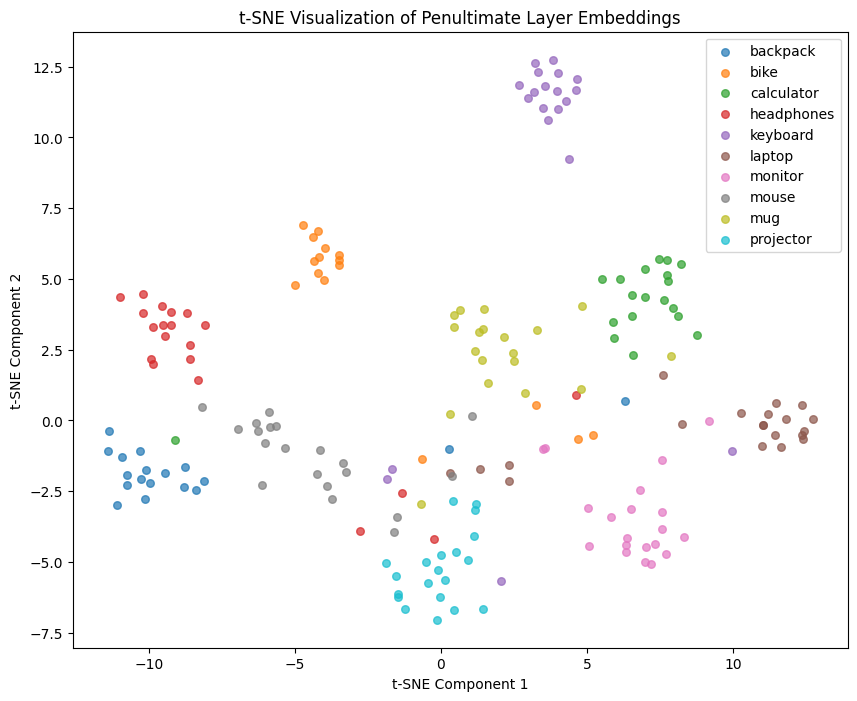

In [6]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.manifold import TSNE

# Define paths relative to the notebook directory
base_dir = "../OfficeCaltechDomainAdaptation/images"
amazon_dir = os.path.join(base_dir, "amazon")

# Custom dataset class for loading images
class AmazonDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Initialize a dictionary to store images by category
categories = {}
for category in os.listdir(amazon_dir):
    category_path = os.path.join(amazon_dir, category)
    if os.path.isdir(category_path):
        categories[category] = []
        # Loop through each image in the category directory
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            # Read image in grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                categories[category].append(image)

# Prepare data and labels for the Amazon subset
X = []
y = []
label_map = {category: idx for idx, category in enumerate(categories.keys())}  # Map category names to indices
for category, images in categories.items():
    for image in images:
        X.append(image)
        y.append(label_map[category])

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create PyTorch datasets and dataloaders
train_dataset = AmazonDataset(X_train, y_train, transform=transform)
val_dataset = AmazonDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load ResNet101 and modify for 10 categories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet101(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fine-tune the model
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract features from the penultimate layer
penultimate_layer_model = nn.Sequential(*list(model.children())[:-1])  # Remove last layer
penultimate_features = []
labels_list = []

# Put the model in evaluation mode
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        features = penultimate_layer_model(images)
        features = features.view(features.size(0), -1)  # Flatten
        penultimate_features.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert to numpy arrays
penultimate_features = np.concatenate(penultimate_features, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# Apply t-SNE to reduce the dimensionality of the penultimate layer features to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(penultimate_features)

# Plot t-SNE results, coloring points by category
plt.figure(figsize=(10, 8))
for category_id in np.unique(labels_list):
    idxs = np.where(labels_list == category_id)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=list(label_map.keys())[category_id], alpha=0.7, s=30)

plt.legend()
plt.title("t-SNE Visualization of Penultimate Layer Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()